# Detección de neumonía
#### Proyecto: AIRE
#### - Luis Carlos Romero Cardenas.
#### - Maria Camila Plazas Gómez.
#### - Alejandra Gómez.
#### - Santiago. 

## 1. Importar datos

In [2]:
!pip install kagglehub

Solo ejecutar si se requiere descargar las imágenes desde Kaggle

In [4]:
# import kagglehub

# # Download latest version
# path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")

# print("Path to dataset files:", path)

100%|██████████| 2.29G/2.29G [08:33<00:00, 4.80MB/s]

Extracting files...


Path to dataset files: C:\Users\Luis Romero\.cache\kagglehub\datasets\paultimothymooney\chest-xray-pneumonia\versions\2


### 1.1. Importar librerias

In [129]:
#librerias estándar
import os
from collections import Counter

#librerias de manejo de datos
import pandas as pd
import numpy as np

#librerias de deep learning
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import metrics
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input


#librerias de visualización
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.utils.class_weight import compute_class_weight


In [127]:

# Ruta completa al conjunto de datos
path=''
data_dir = os.path.join(path, 'Data', 'chest_xray')
data_dir

# Cargar las imágenes desde las carpetas train, test y val
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')
val_dir = os.path.join(data_dir, 'val')

# Crear datasets para train, test y val
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    image_size=(256, 256),
    batch_size=32,
    #shuffle=True 
)

test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    image_size=(256, 256),
    batch_size=32,
    shuffle=False 
)

val_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    val_dir,
    image_size=(256, 256),
    batch_size=32
)

print("Datasets cargados exitosamente.")

Found 5216 files belonging to 2 classes.
Found 624 files belonging to 2 classes.
Found 16 files belonging to 2 classes.
Datasets cargados exitosamente.


### 1.2 Determinar el tamaño original de las imágenes.

In [19]:
image_paths = []
for root, dirs, files in os.walk(train_dir):
    for file in files:
        if file.lower().endswith(('jpg', 'jpeg', 'png')):
            image_paths.append(os.path.join(root, file))

# Mostrar dimensiones originales de las primeras 5 imágenes
for path in image_paths[:5]:
    img_raw = tf.io.read_file(path)
    img = tf.image.decode_image(img_raw)
    print(f"{os.path.basename(path)}: {img.shape}")

IM-0115-0001.jpeg: (1858, 2090, 1)
IM-0117-0001.jpeg: (1152, 1422, 1)
IM-0119-0001.jpeg: (1434, 1810, 1)
IM-0122-0001.jpeg: (1279, 1618, 1)
IM-0125-0001.jpeg: (1125, 1600, 1)


Debido al tamaño de promedio de cada imagen y que podría impactar el rendimiento en el entrenamiento del modelo se hará un reescalado de cada imagen a un tamaño estandar de 256 x 256 pixels. Adicional, se evidencia que son imágenes en escala de grises

### 1.3. Muestra de los datos

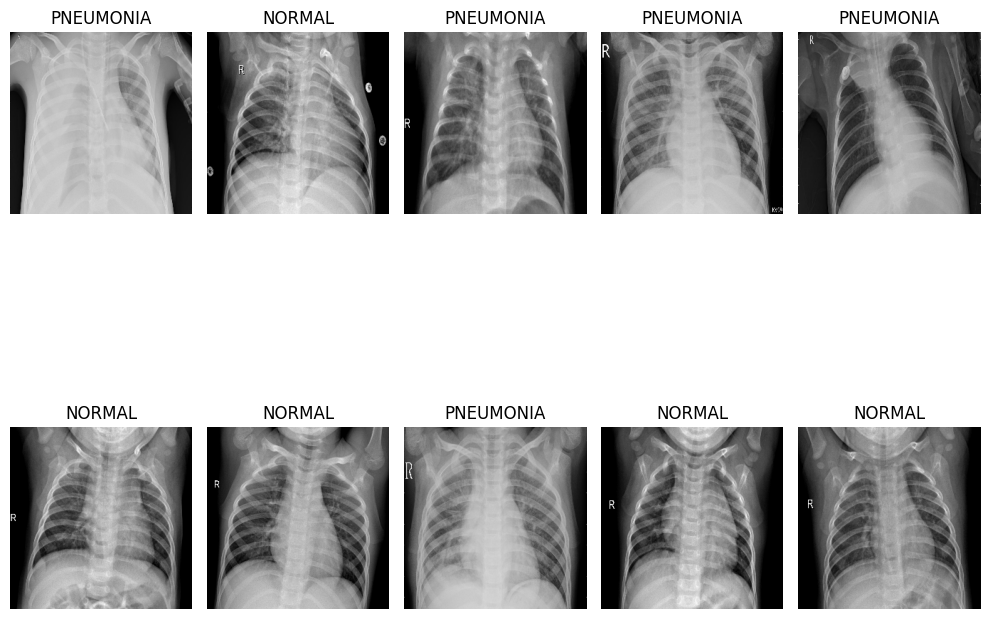

In [9]:

# Obtener las clases del conjunto de entrenamiento
class_names = train_dataset.class_names

# Inicializar contadores para las categorías
category_counts = {class_name: 0 for class_name in class_names}
max_images_per_category = 5

# Crear una lista para almacenar las imágenes y etiquetas
images_to_plot = []
labels_to_plot = []

# Iterar sobre el conjunto de entrenamiento
for images, labels in train_dataset:
    for image, label in zip(images, labels):
        class_name = class_names[label.numpy()]
        if category_counts[class_name] < max_images_per_category:
            images_to_plot.append(image)
            labels_to_plot.append(class_name)
            category_counts[class_name] += 1
        # Romper el bucle si ya tenemos suficientes imágenes
        if all(count >= max_images_per_category for count in category_counts.values()):
            break
    if all(count >= max_images_per_category for count in category_counts.values()):
        break

# Graficar las imágenes
plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(zip(images_to_plot, labels_to_plot)):
    plt.subplot(2, max_images_per_category, i + 1)
    plt.imshow(image.numpy().astype("uint8"))
    plt.title(label)
    plt.axis("off")
plt.tight_layout()
plt.show()

# 2. Preprocesar Datos

### 2.1. Determinar las características del conjunto de datos:


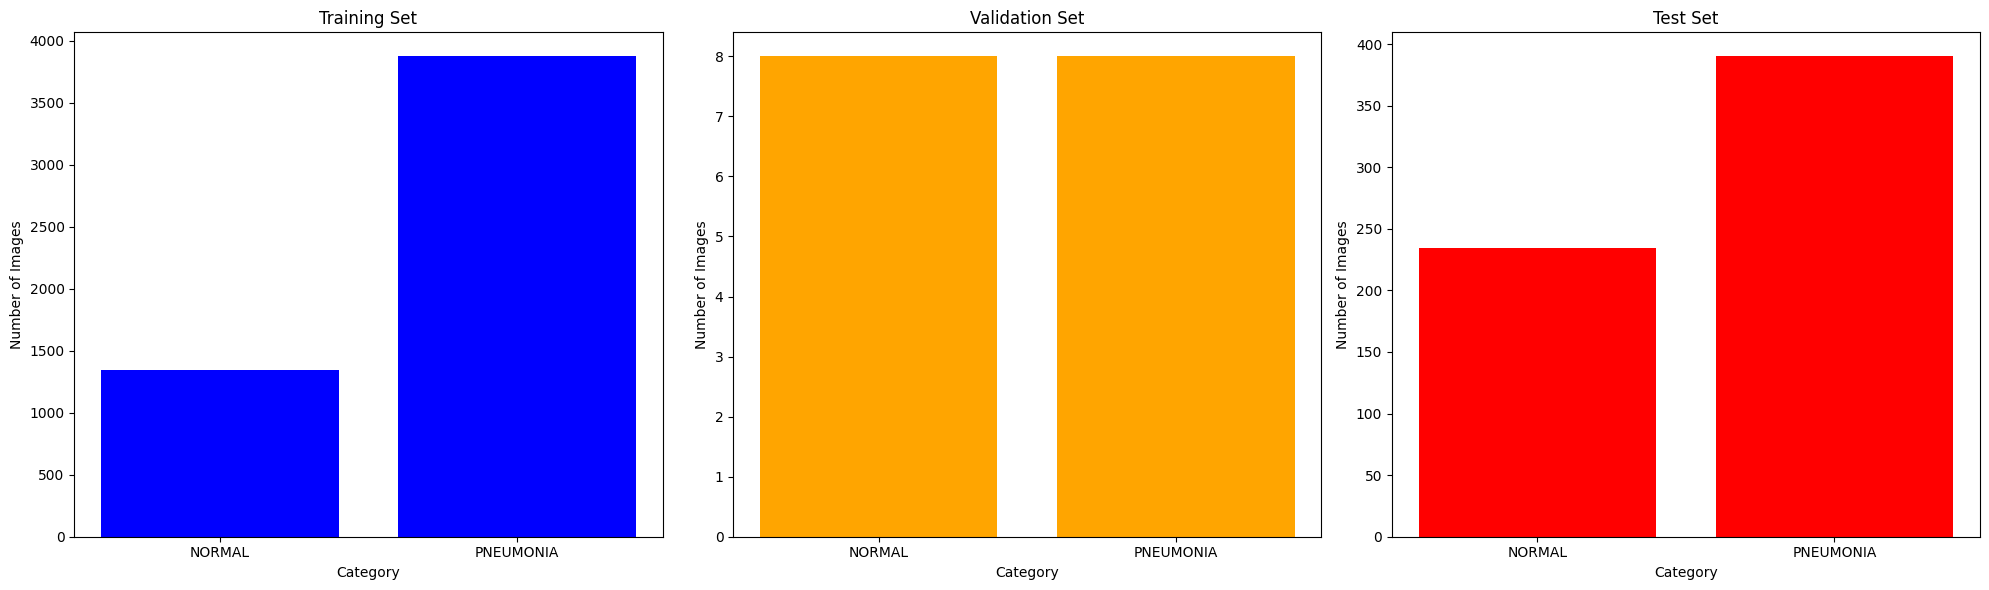

Número de imágenes por categoría en el conjunto de entrenamiento: [1341 3875]
Número de imágenes por categoría en el conjunto de validación: [8 8]
Número de imágenes por categoría en el conjunto de prueba: [234 390]


In [16]:
categories = train_dataset.class_names

# Función para contar las ocurrencias por clase
def count_labels(dataset, num_classes):
    all_labels = []
    for images, labels in dataset:
        all_labels.extend(labels.numpy())
    counts = np.bincount(all_labels, minlength=num_classes)
    return counts

# Obtener los conteos
num_classes = len(categories)
train_counts = count_labels(train_dataset, num_classes)
val_counts = count_labels(val_dataset, num_classes)
test_counts = count_labels(test_dataset, num_classes)

# Crear una figura y ejes
fig, ax = plt.subplots(1, 3, figsize=(20, 6))

# Gráficos
ax[0].bar(categories, train_counts, color='blue')
ax[0].set_title('Training Set')
ax[0].set_xlabel('Category')
ax[0].set_ylabel('Number of Images')

ax[1].bar(categories, val_counts, color='orange')
ax[1].set_title('Validation Set')
ax[1].set_xlabel('Category')
ax[1].set_ylabel('Number of Images')

ax[2].bar(categories, test_counts, color='red')
ax[2].set_title('Test Set')
ax[2].set_xlabel('Category')
ax[2].set_ylabel('Number of Images')

plt.tight_layout()
plt.show()

print("Número de imágenes por categoría en el conjunto de entrenamiento:", train_counts)
print("Número de imágenes por categoría en el conjunto de validación:", val_counts)
print("Número de imágenes por categoría en el conjunto de prueba:", test_counts)

Se logra evidenciar un desbalanceo del tamaño por cada categoría, en los conjuntos de entrenamiento y prueba. Lo que reuiqre aplicar técnicas para el manejar el desbalanceo y que no afecte el entrenamiento.

### 2.2. Aplicar la técnica de aumento de datos para el conjunto de datos de entrenamiento únicamente:

In [125]:
# Aumento de datos definido como un modelo secuencial
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.08),
    layers.RandomZoom(0.08),
    layers.RandomTranslation(0.08, 0.08),
    layers.RandomContrast(0.08),
])

# Cargar dataset desde carpeta
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    image_size=(256, 256),
    batch_size=32
)

# Aplicar el aumento de datos solo al entrenamiento
# (no lo aplicamos a validación ni prueba)
train_dataset = train_dataset.map(lambda x, y: (data_augmentation(x, training=True), y))

Found 5216 files belonging to 2 classes.


# 3. Modelo 
### 3.1. Definir parámetros del modelo:

In [66]:
size_filter=(3, 3)
input_shape = (256, 256, 3)
size_classes = len(class_names)
epochs = 30
batch_size = 32
val_image_count = sum([len(files) for r, d, files in os.walk(val_dir) if files])
validation_steps=val_image_count//batch_size
train_image_count = sum([len(files) for r, d, files in os.walk(train_dir) if files])
train_steps=train_image_count//batch_size
test_image_count = sum([len(files) for r, d, files in os.walk(test_dir) if files])
test_steps=test_image_count//batch_size
labels_names = ['NORMAL', 'PNEUMONIA']

### 3.2 Definir el modelo de CNN

In [41]:
model = models.Sequential([
    layers.Conv2D(32,size_filter , activation='relu', input_shape=input_shape,
                  kernel_regularizer=regularizers.l2(0.001)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, size_filter, activation='relu',
                  kernel_regularizer=regularizers.l2(0.001)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, size_filter, activation='relu',
                  kernel_regularizer=regularizers.l2(0.001)),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu',
                 kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.5),  # Añadir Dropout con una tasa del 50%
    layers.Dense(size_classes, activation='softmax')
])


### 3.3. Compilar el modelo

In [44]:

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=[
                  'accuracy',
                  metrics.Precision(name='precision'),
                  metrics.Recall(name='recall')
                  ])
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 115200)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │    14,745,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,839,234 (56.61 MB)

 Trainable params: 14,839,234 (56.61 MB)

 Non-trainable params: 0 (0.00 B)

### 3.4.  Entrenar el modelo

In [45]:
history = model.fit(
    train_dataset,
    steps_per_epoch=train_steps,
    validation_data=val_dataset,
    validation_steps=validation_steps,
    epochs=epochs
)


Epoch 1/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 192s 1s/step - accuracy: 0.6957 - loss: 28.9797 - val_accuracy: 0.4375 - val_loss: 1.4235
Epoch 2/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.4375 - val_loss: 1.4235
Epoch 3/30


c:\ProgramData\anaconda3\envs\mlops\Lib\contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


163/163 ━━━━━━━━━━━━━━━━━━━━ 179s 1s/step - accuracy: 0.7857 - loss: 0.8373 - val_accuracy: 0.5000 - val_loss: 2.6420
Epoch 4/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.5000 - val_loss: 2.6420
Epoch 5/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 186s 1s/step - accuracy: 0.7774 - loss: 0.8026 - val_accuracy: 0.6250 - val_loss: 1.2000
Epoch 6/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.6250 - val_loss: 1.2000
Epoch 7/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 181s 1s/step - accuracy: 0.7782 - loss: 1.0276 - val_accuracy: 0.7500 - val_loss: 0.9236
Epoch 8/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.7500 - val_loss: 0.9236
Epoch 9/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 171s 1s/step - accuracy: 0.8026 - loss: 0.7367 - val_accuracy: 0.5625 - val_loss: 1.0156
Epoch 10/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0000e+00 - loss: 0.0

### 3.4. Evaluar el modelo en el conjunto de prueba

In [56]:

test_loss, test_acc = model.evaluate(test_dataset)
print(f'Test accuracy: {test_acc}')

20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 223ms/step - accuracy: 0.4135 - loss: 1.3995
Test accuracy: 0.6682692170143127


### 3.5 Métricas

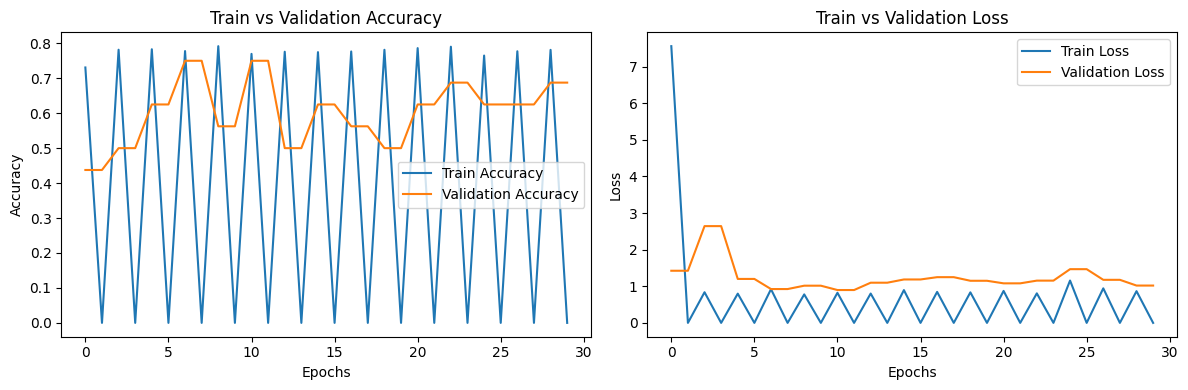

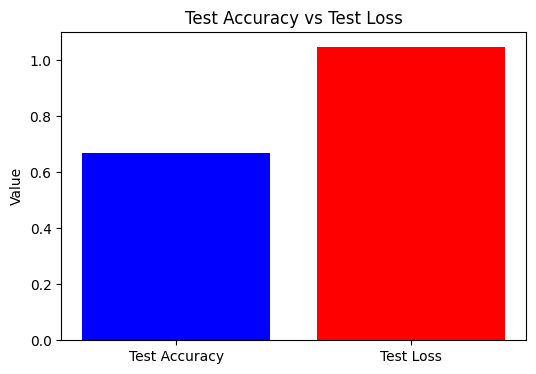

In [57]:

# Precisión
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train vs Validation Accuracy')
plt.legend()

# Pérdida
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train vs Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Graficar precisión del test vs pérdida del test
# Notar que esto no es por época sino un solo punto después de evaluar el conjunto de prueba
plt.figure(figsize=(6, 4))
plt.bar(['Test Accuracy', 'Test Loss'], [test_acc, test_loss], color=['blue', 'red'])
plt.ylabel('Value')
plt.title('Test Accuracy vs Test Loss')
plt.show()
     


### 3.6 Reporte de clasificación

Longitudes: 624 624


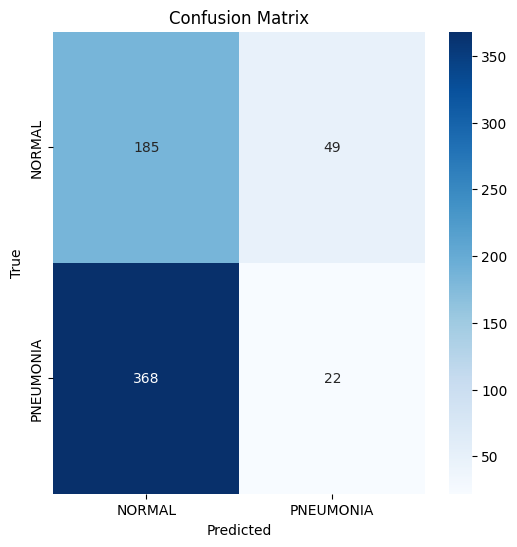

              precision    recall  f1-score   support

      NORMAL       0.33      0.79      0.47       234
   PNEUMONIA       0.31      0.06      0.10       390

    accuracy                           0.33       624
   macro avg       0.32      0.42      0.28       624
weighted avg       0.32      0.33      0.24       624



In [64]:
y_true = []
y_pred = []

for images, labels in test_dataset.unbatch():
    image = tf.expand_dims(images, axis=0)  # convertir (256, 256, 3) -> (1, 256, 256, 3)
    pred = model(image, training=False)     # predicción directa sin .predict()
    y_pred.append(int(pred.numpy().flatten()[0] > 0.5))  # umbral binario
    y_true.append(int(labels.numpy()))

# Convertir a arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)

print("Longitudes:", len(y_true), len(y_pred))

cm = confusion_matrix(y_true, y_pred)


plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels_names, yticklabels=labels_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

reporte_modelo_1 = classification_report(y_true, y_pred, target_names=labels_names,output_dict=True)
print(classification_report(y_true, y_pred, target_names=labels_names))

#### 3.6.1. Con datos de validación

Longitudes: 16 16


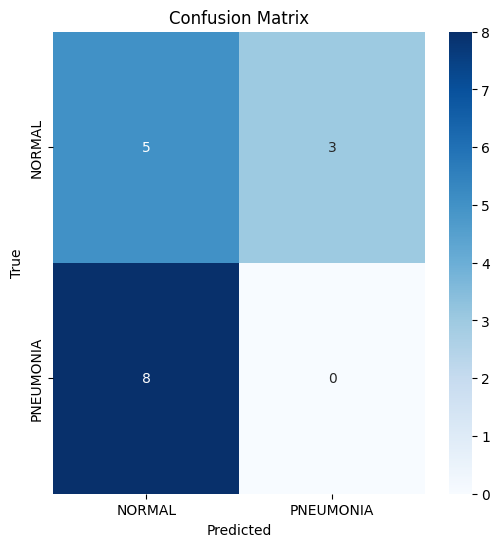

              precision    recall  f1-score   support

      NORMAL       0.38      0.62      0.48         8
   PNEUMONIA       0.00      0.00      0.00         8

    accuracy                           0.31        16
   macro avg       0.19      0.31      0.24        16
weighted avg       0.19      0.31      0.24        16



In [65]:
y_true = []
y_pred = []

for images, labels in val_dataset.unbatch():
    image = tf.expand_dims(images, axis=0)  # convertir (256, 256, 3) -> (1, 256, 256, 3)
    pred = model(image, training=False)     # predicción directa sin .predict()
    y_pred.append(int(pred.numpy().flatten()[0] > 0.5))  # umbral binario
    y_true.append(int(labels.numpy()))

# Convertir a arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)

print("Longitudes:", len(y_true), len(y_pred))

cm = confusion_matrix(y_true, y_pred)
labels_names = ['NORMAL', 'PNEUMONIA']

plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels_names, yticklabels=labels_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

print(classification_report(y_true, y_pred, target_names=labels_names))

### 3.7 Curva ROC

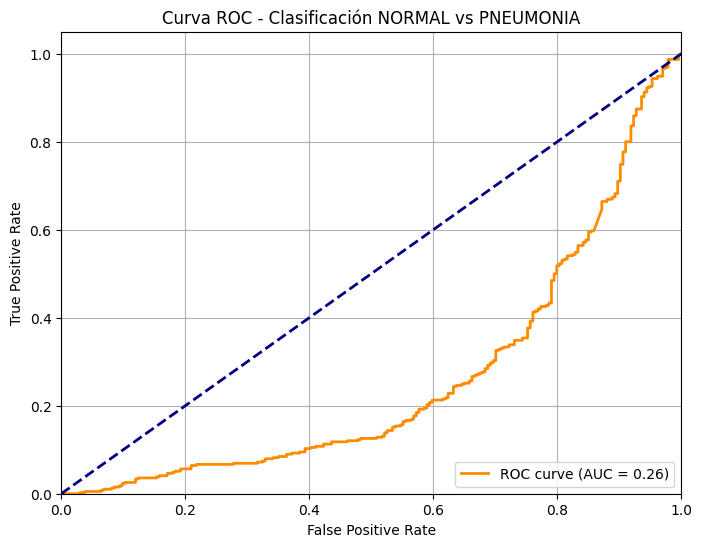

In [67]:
y_true = []
y_pred_prob = []

for images, labels in test_dataset.unbatch():
    image = tf.expand_dims(images, axis=0)
    pred = model(image, training=False).numpy().flatten()[0]
    y_pred_prob.append(pred)
    y_true.append(int(labels.numpy()))

# Convertir a arrays
y_true = np.array(y_true)
y_pred_prob = np.array(y_pred_prob)

# Calcular curva ROC
fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Graficar curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC - Clasificación NORMAL vs PNEUMONIA')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

#### 3.7.1 Curva ROC datos de validación

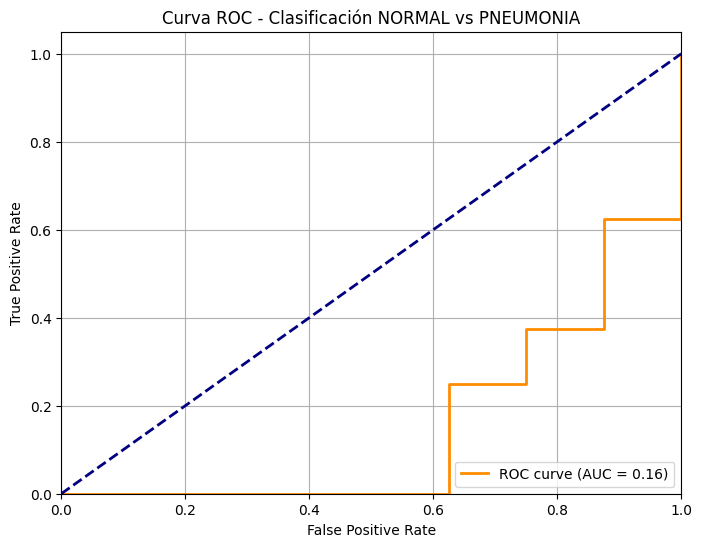

In [68]:
y_true = []
y_pred_prob = []

for images, labels in val_dataset.unbatch():
    image = tf.expand_dims(images, axis=0)
    pred = model(image, training=False).numpy().flatten()[0]
    y_pred_prob.append(pred)
    y_true.append(int(labels.numpy()))

# Convertir a arrays
y_true = np.array(y_true)
y_pred_prob = np.array(y_pred_prob)

# Calcular curva ROC
fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Graficar curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC - Clasificación NORMAL vs PNEUMONIA')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

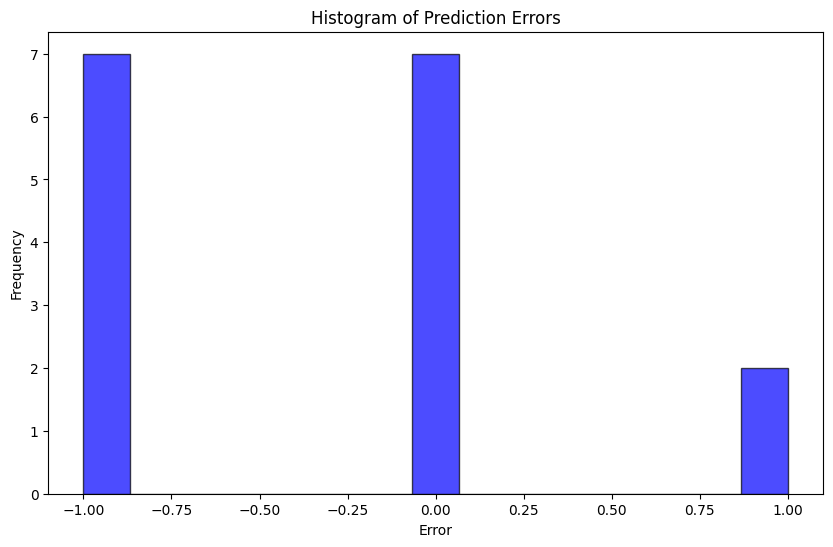

In [69]:
errors = y_pred - y_true

# Graficar el histograma de la distribución de errores
plt.figure(figsize=(10, 6))
#plt.hist(errors, bins=np.arange(errors.min(), errors.max()+1), alpha=0.7, color='blue', edgecolor='black')
plt.hist(errors, bins=15, alpha=0.7, color='blue', edgecolor='black')
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.title('Histogram of Prediction Errors')
plt.show()


# 4 Modelo 2

## 4.1 Asignación de pesos por desbalanceo de los datos.

In [128]:
class_names = train_dataset.class_names
samples_per_class = {
    "NORMAL": 1341,
    "PNEUMONIA": 3875
}
class_indices = {name: i for i, name in enumerate(class_names)}
y_labels = []
sample_counts = []

for name in class_names:
    y_labels.append(class_indices[name])
    sample_counts.append(samples_per_class[name])

# Calcular pesos balanceados
weights = compute_class_weight(class_weight='balanced', classes=np.array(y_labels), y=np.repeat(y_labels, sample_counts))
class_weights = dict(zip(y_labels, weights))
print("Pesos aplicados:", class_weights)


Pesos aplicados: {0: 1.9448173005219984, 1: 0.6730322580645162}


In [130]:
# Carga de la ResNet50 preentrenada (sin la última capa)
base_model = ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(256, 256, 3)
)
base_model.trainable = False  # Congelar pesos

# Construcción del modelo final
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(len(class_names), activation='softmax')
])


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 21s 0us/step


In [131]:
model.summary()

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ ?                      │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ ?                      │   0 (unbuilt) │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 23,587,712 (89.98 MB)

In [133]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['sparse_categorical_accuracy']
)

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=30,
    callbacks=[early_stop],
    class_weight=class_weights
)

Epoch 1/30


163/163 ━━━━━━━━━━━━━━━━━━━━ 306s 2s/step - loss: 0.4412 - sparse_categorical_accuracy: 0.8054 - val_loss: 0.3272 - val_sparse_categorical_accuracy: 0.8750
Epoch 2/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 287s 2s/step - loss: 0.1457 - sparse_categorical_accuracy: 0.9428 - val_loss: 0.3489 - val_sparse_categorical_accuracy: 0.8125
Epoch 3/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 295s 2s/step - loss: 0.1085 - sparse_categorical_accuracy: 0.9568 - val_loss: 0.4859 - val_sparse_categorical_accuracy: 0.7500
Epoch 4/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 294s 2s/step - loss: 0.0987 - sparse_categorical_accuracy: 0.9662 - val_loss: 0.2244 - val_sparse_categorical_accuracy: 0.8750
Epoch 5/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 289s 2s/step - loss: 0.0974 - sparse_categorical_accuracy: 0.9605 - val_loss: 0.2605 - val_sparse_categorical_accuracy: 0.8750
Epoch 6/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 291s 2s/step - loss: 0.0767 - sparse_categorical_accuracy: 0.9723 - val_loss: 0.1465 - val_sparse_categorical_accuracy: 0.9375
Epoch 7/3

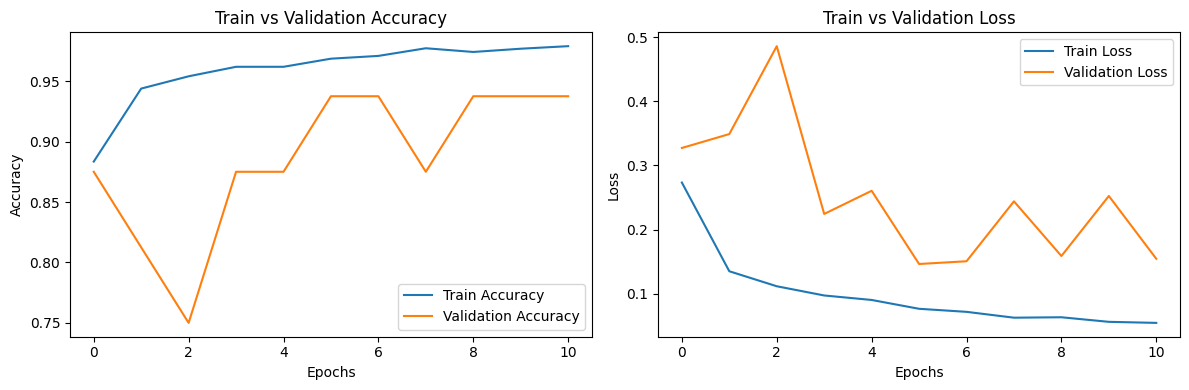

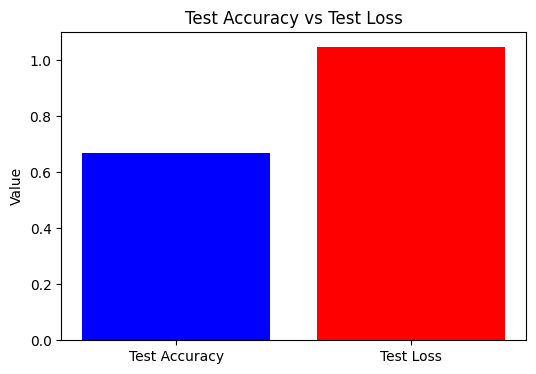

In [136]:

# Precisión
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['sparse_categorical_accuracy'], label='Train Accuracy')
plt.plot(history.history['val_sparse_categorical_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train vs Validation Accuracy')
plt.legend()

# Pérdida
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train vs Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Graficar precisión del test vs pérdida del test
# Notar que esto no es por época sino un solo punto después de evaluar el conjunto de prueba
plt.figure(figsize=(6, 4))
plt.bar(['Test Accuracy', 'Test Loss'], [test_acc, test_loss], color=['blue', 'red'])
plt.ylabel('Value')
plt.title('Test Accuracy vs Test Loss')
plt.show()
     


In [151]:
# Evaluación después de entrenar
y_true = []
y_pred = []

for x_batch, y_batch in test_dataset.unbatch():
    y_true.append(y_batch.numpy())
    pred = model.predict(tf.expand_dims(x_batch, 0))
    y_pred.append(np.argmax(pred))

print(classification_report(y_true, y_pred, target_names=class_names))
model_2_reporte=classification_report(y_true, y_pred, target_names=class_names,output_dict=True)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━

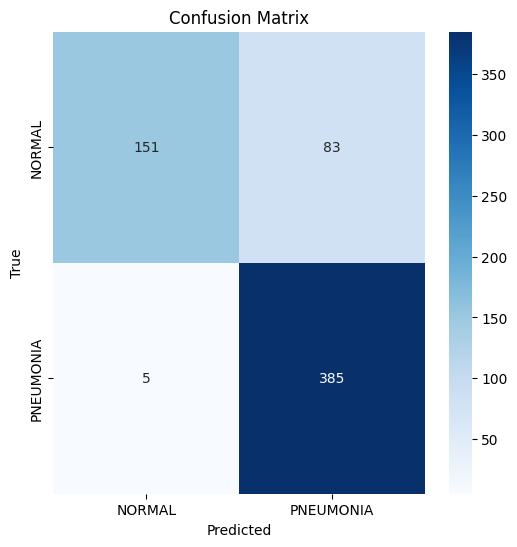

In [152]:
cm = confusion_matrix(y_true, y_pred)
labels_names = ['NORMAL', 'PNEUMONIA']

plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels_names, yticklabels=labels_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [153]:
# Evaluación después de entrenar
y_true_val = []
y_pred_val = []

for x_batch, y_batch in val_dataset.unbatch():
    y_true_val.append(y_batch.numpy())
    pred = model.predict(tf.expand_dims(x_batch, 0))
    y_pred_val.append(np.argmax(pred))

print(classification_report(y_true_val, y_pred_val, target_names=class_names))
model_2_reporte=classification_report(y_true_val, y_pred_val, target_names=class_names,output_dict=True)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
              precision    recall  f1-score   support

      NORMAL       1.00      0.88      0.93         8
   PNEUMONIA       0.89      1.00      0.94         8

    accuracy                           0.94        16
   macro avg       0.94      0.94      0.94        16
weighted avg       0.94      0.94      0.94        16



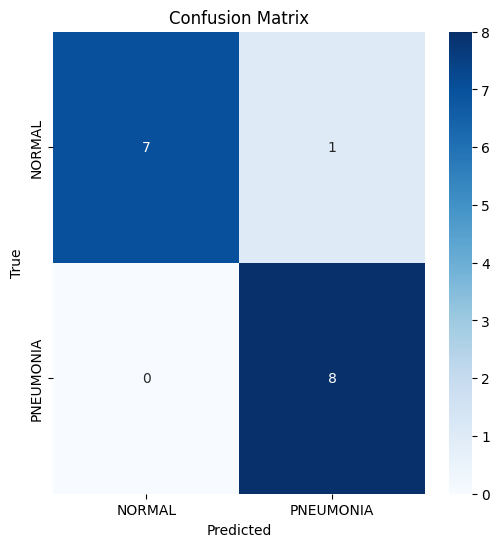

In [154]:
cm = confusion_matrix(y_true_val, y_pred_val)
labels_names = ['NORMAL', 'PNEUMONIA']

plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels_names, yticklabels=labels_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

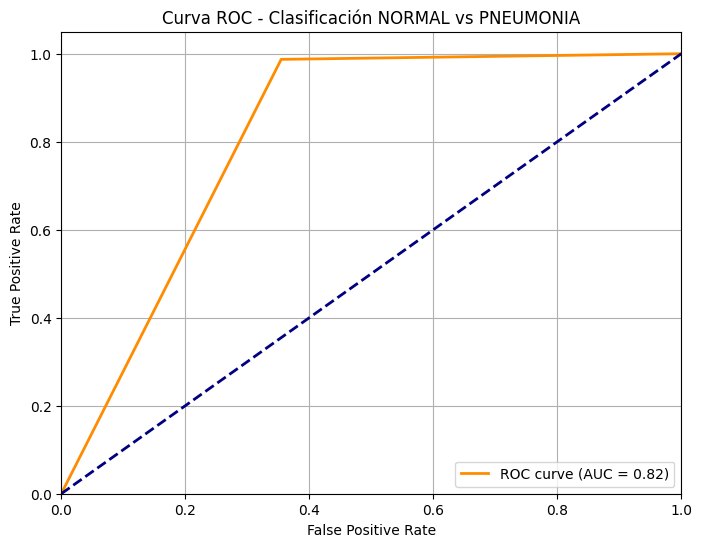

In [155]:
# Convertir a arrays
y_true_prob = np.array(y_true)
y_pred_prob = np.array(y_pred)

# Calcular curva ROC
fpr, tpr, _ = roc_curve(y_true_prob, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Graficar curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC - Clasificación NORMAL vs PNEUMONIA')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

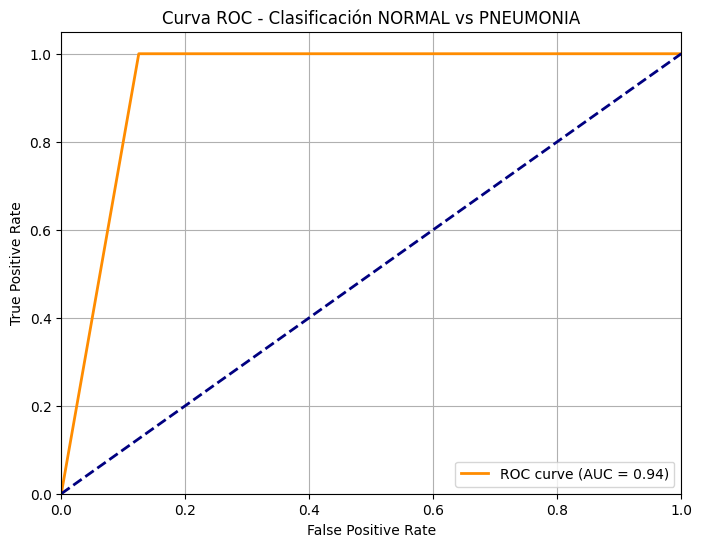

In [156]:
# Convertir a arrays
y_true_prob_val = np.array(y_true_val)
y_pred_prob_val = np.array(y_pred_val)

# Calcular curva ROC
fpr, tpr, _ = roc_curve(y_true_prob_val, y_pred_prob_val)
roc_auc = auc(fpr, tpr)

# Graficar curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC - Clasificación NORMAL vs PNEUMONIA')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

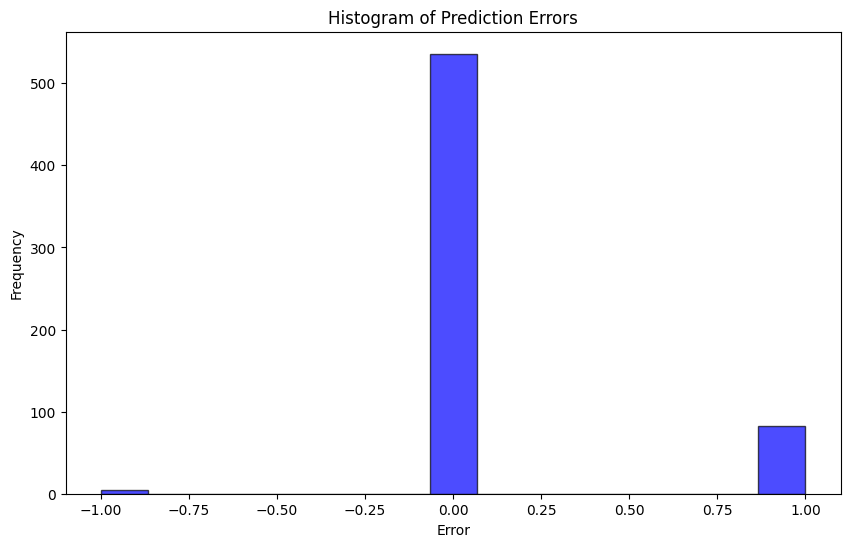

In [158]:
errors = np.array(y_pred) - np.array(y_true)

# Graficar el histograma de la distribución de errores
plt.figure(figsize=(10, 6))
#plt.hist(errors, bins=np.arange(errors.min(), errors.max()+1), alpha=0.7, color='blue', edgecolor='black')
plt.hist(errors, bins=15, alpha=0.7, color='blue', edgecolor='black')
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.title('Histogram of Prediction Errors')
plt.show()

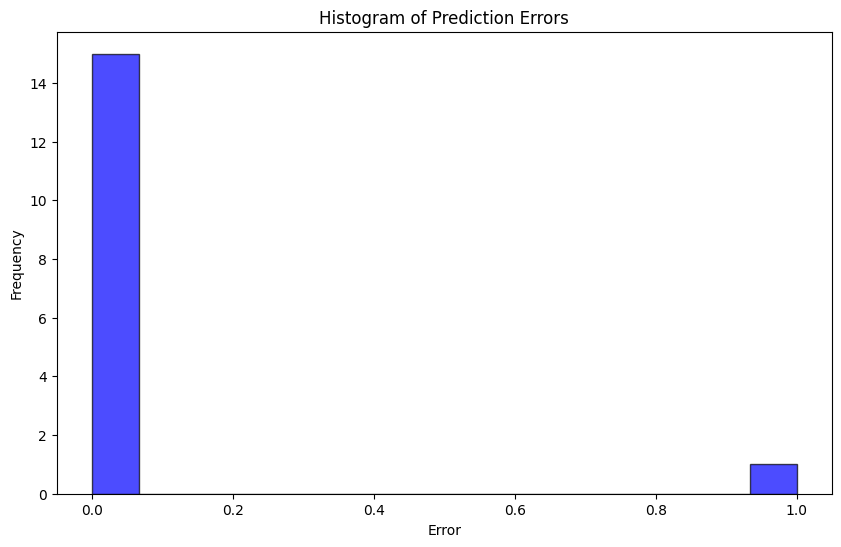

In [159]:
errors = np.array(y_pred_val) - np.array(y_true_val)

# Graficar el histograma de la distribución de errores
plt.figure(figsize=(10, 6))
#plt.hist(errors, bins=np.arange(errors.min(), errors.max()+1), alpha=0.7, color='blue', edgecolor='black')
plt.hist(errors, bins=15, alpha=0.7, color='blue', edgecolor='black')
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.title('Histogram of Prediction Errors')
plt.show()